In [1]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: da24s006 (da24s006-indian-institue-of-technology-madras-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(project='Backprop_From_Scratch')

In [4]:
import matplotlib.pyplot as plt 
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

**Question 1(2 Marks):**

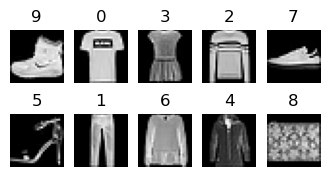

In [6]:
plotted, plot_no = [], 1
plt.figure(figsize=(4, 2))

# Initialize W&B run
wandb.init(project="backprop-from-scratch", name="plot_unique_labels")
for index, label in enumerate(train_labels): 

    if len(plotted) == len(set(train_labels)):
        break
        
    if label not in plotted: 
        plt.subplot(2, 5, plot_no)
        plt.imshow(train_images[index], cmap='grey')
        plotted.append(label)
        plt.title(f'{label}')
        plt.axis("off")
        plot_no += 1

# getting the final figure
fig = plt.gcf()

#loggint the figure of wandb
wandb.log({"unique_labels_plot": wandb.Image(fig)})

plt.show()
wandb.finish()

**Question 2(10 Marks):**

In [265]:
import numpy as np 

# defining a backprop_from_scratch to do all.
class backprop_from_scratch:

    # define constructor
    def __init__(self, layer_size):
        # initialise the neural network
        self.weights, self.biases = [], []
        self.num_layers = len(layer_size)
        self.layer_sizes = layer_size
        self.initialize_params()
        
    def initialize_params(self):
        # let's use He initialization for weights and set values of bias equals to zero
        for i in range(self.num_layers-1):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w) 
            self.biases.append(b) 
            
    def forward_pass(self, data_X):
        activations = [data_X]
        # pass thorugh hidden layers
        for i in range(self.num_layers - 2): 
            
            # print("ran")
            # print(activations[-1].shape)
            # print(self.weights[i].shape)
            # print(self.biases[i].shape)
            
            a = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            h = self.sigmoid(a)
            activations.append(h)
        # pass thorugh the output layer
        a = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        output = self.softmax(a)
        activations.append(output)
        return activations

    def sigmoid(self, X):
        # clipping it bw -500 to 500 
        return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
    
    def sigmoid_derivative(self, x):
        return x*(1-x) 
        
    def softmax(self, X): 
        # clipping it for numerical stability
        exp_x = np.exp(X - np.max(X, axis = 1, keepdims=True))
        return exp_x/np.sum(exp_x, axis = 1, keepdims=True)
        
    def backword_pass(self, X, y, activations, learning_rate):
        # compute the gradient at given value of params
        batch_size = len(X)
        # computing gradies with repect to the output layer 
        delta = activations[-1] - y
        # computing gradient with respect to hidden layers
        for i in range(self.num_layers - 2, -1, -1):
            dw = np.dot(activations[i].T, delta) / batch_size
            db = np.sum(delta, axis=0, keepdims=True) / batch_size
            if i>0: 
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(activations[i])
            self.weights[i] -= dw
            self.biases[i] -= db
        
    # function to train the network
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
        for epoch in range(epochs): 
            # first shuffle the training data
            # print(X_train.shape[0])
            
            indices = np.random.permutation(X_train.shape[0]) 
            X_train_permuted = X_train[indices]
            y_train_permuted = y_train[indices]
            
            total_loss = 0
            batch_num = 0
            
            # let's make a update for a mini batch
            for i in range(0, X_train.shape[0], batch_size): 
                batch_x = X_train_permuted[i: i + batch_size]
                batch_y = y_train_permuted[i: i + batch_size]
                activations = self.forward_pass(batch_x)
                loss = -np.mean(np.sum(batch_y * np.log(activations[-1] + 1e-10), axis = 1)) # to prevent numberical underflow
                total_loss += loss
                batch_num += 1
                self.backword_pass(batch_x, batch_y, activations, learning_rate)
            
            average_loss = total_loss/batch_num
            print(average_loss)  
            
            # now let's make predictions on validation dataset 
            validation_predictions = self.predict(X_val)
            validation_accuracy = np.mean(validation_predictions == np.argmax(y_val, axis = 1))

            # loging to wandb
            wandb.log({'epoch': epoch , 'train_loss': average_loss, 'val_accuracy': validation_accuracy})
            print(f"epoch: {epoch}, train_loss:{average_loss:.4f}, val_accuracy: {validation_accuracy:.4f}")
            
    def predict(self, X): 
        # this will predict class labels for the passed data
        activations = self.forward_pass(X)
        return np.argmax(activations[-1], axis=1)
    

In [ ]:
# Splitting the trainig data into train and validation

indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)
train_size = 50000
train_x = train_images[indices[:train_size]]
train_y = train_labels[indices[:train_size]]
val_x = train_images[indices[train_size:]]
val_y = train_labels[indices[train_size:]]

train_x = train_x.reshape(train_x.shape[0], -1)
val_x = val_x.reshape(val_x.shape[0], -1)

# train_x.ravel()
# val_y.ravel()

# converting y's into one hot vector
num_classes = 10
train_y = np.eye(num_classes)[train_y]
val_y = np.eye(num_classes)[val_y]

# initializing hyperparms in wandb
wandb.init(project='backprop_scratch', 
           config={ 'Learning_rate' : 0.1, 
                    'epochs' : 50, 
                    'batch_size' : 32, 
                    'layer_size' : [784, 128, 64, 10]})

config = wandb.config

# now let's create and train the network
model = backprop_from_scratch(config.layer_size)
model.train(train_x, train_y, val_x, val_y, config.epochs, config.Learning_rate, config.batch_size)

# now let's evaluate on the test set
test_predictions = model.predict(test_images) # yet to reshape
test_accuracy = np.mean(test_predictions == np.argmax(test_labels, axis = 1))
print(f"test_accuracy:{test_accuracy: .4f}") 
wandb.log({'test_accuracy': test_accuracy})


2.7009121729070635
2.3676650107589
3.704408032925762
3.813834701701872
2.5111332926485157
2.2759131500523293
2.382834385716025
2.337238785801934
2.2943546673524047
2.2882139798207106
2.2751830891939058
2.2073137907043168
2.3222319431523943
2.1834651923291917
2.2713544155721053
2.2683534105103442
2.2680930800347343
2.2433788262409835
2.253420219612665
2.286538818734236
2.1965171906133416
2.1147946548174574
2.281749801975902
2.259099807478143
2.1205969117915595
2.1256506985741375
2.2756957247143457
2.133337391393345
2.159709586124828
2.1037405260598847
2.2643649215817776
2.1416297276561425
2.3180337785875897
2.5210981690262084
2.282261641941261
2.2021797885925523
2.1687916591596483
2.241418088130274
2.1882756131994308
2.1398369931208885
2.184229848108328
2.225148616995245
2.0812008061390515
2.112749198914671
1.8751881257643181
2.3722694264798863
2.5909760071584738
2.2160987887324852
2.160789947441567
2.184358250110633
2.2034293222919423
2.2205684471582274
2.2859636735308375
2.19344880727

In [56]:
indices = np.random.permutation(10) 

In [58]:
indices

array([6, 5, 8, 0, 7, 9, 2, 1, 4, 3])